In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, RidgeClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.base import BaseEstimator
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as sw
from nltk.tokenize import TweetTokenizer
import nltk
import re
import string
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

%matplotlib inline
sns.set_style("white")

FEATURE_LIST = ['created_at', 'id', 'full_text', 'user', 'retweet_count', 'favorite_count', 'coordinates', 'place', 'class']
N_BINS = 18
IMAGE_PATH = 'images/'

stopwords = sw.words('english') + ["'d", "'ll", "'re", "'s", "'ve", 'doe', 'ha', "n't", 'sha', 'wa', 'wo']

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
class LemmaTokenizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.tokenizer = TweetTokenizer()

    def __call__(self, document):
        lemmas = []
        re_digit = re.compile("[0-9]") # regular expression to filter digit tokens
        re_emoji = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

        for t in self.tokenizer.tokenize(document):
            t.strip()
            lemma = self.lemmatizer.lemmatize(t)

            # remove tokens with only punctuation chars and digits
            if  re_emoji.match(lemma) or (
                lemma not in string.punctuation and
                len(lemma) > 2 and
                not re_digit.match(lemma)
                ):
                lemmas.append(lemma)

        return lemmas

class ClfSwitcher(BaseEstimator):

    def __init__(
        self,
        estimator = SGDClassifier(),
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

def generate_wordclouds(X, X_tfidf, k, word_positions):
    """Cluster X with K-means with the specified k, and generate one wordcloud per cluster.

    :input X: numpy.array or numpy.matrix to cluster
    :input X_tfidf: sparse matrix with TFIDF values
    :input k: the k to be used in K-means
    :input word_positions: dictionary with pairs as word index (in vocabulary) -> word
    :return cluster_ids: set with the clusters ids
    """

    model = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
    y_pred = model.fit_predict(X)
    cluster_ids = set(y_pred)
    top_count = 100

    for cluster_id in cluster_ids:

        # compute the total tfidf for each term in the cluster
        tfidf = X_tfidf[y_pred == cluster_id]
        tfidf_sum = np.sum(tfidf, axis=0) # numpy.matrix
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1) # numpy.array of shape (1, X.shape[1])
        top_indices = tfidf_sum.argsort()[-top_count:]

        term_weights = {word_positions[idx]: tfidf_sum[idx] for idx in top_indices}
        wc = WordCloud(width=1200, height=800, background_color="black")
        wordcloud = wc.generate_from_frequencies(term_weights)

        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {cluster_id}")

    return cluster_ids

In [3]:
training_set = pd.read_json('development.jsonl', lines=True)
training_set = training_set[FEATURE_LIST]

test_set = pd.read_json('evaluation.jsonl', lines=True)

In [8]:
n_positive = training_set.loc[training_set['class'] == 1, 'class'].count()
n_negative = training_set.loc[training_set['class'] == 0, 'class'].count()

n_null_coord = training_set['coordinates'].isna().sum()
n_null_place = training_set['place'].isna().sum()

# number of tweets with 0 as 'favorite_count'
n_pos_favcount = training_set.loc[(training_set['class'] == 0) & (training_set['favorite_count'] == 0), 'favorite_count'].count() / len(training_set) * 100
n_neg_favcount = training_set.loc[(training_set['class'] == 1) & (training_set['favorite_count'] == 0), 'favorite_count'].count() / len(training_set) * 100

median_neg_retweet = training_set.loc[training_set['class'] == 0, 'retweet_count'].median()
median_pos_retweet = training_set.loc[training_set['class'] == 1, 'retweet_count'].median()

median_neg_favcount = training_set.loc[training_set['class'] == 0, 'favorite_count'].median()
median_pos_favcount = training_set.loc[training_set['class'] == 1, 'favorite_count'].median()

tweet_len = [len(tweet) for tweet in training_set['full_text']]
training_set['tweet_len'] = tweet_len

median_pos_len = training_set.loc[training_set['class'] == 1, 'tweet_len'].median()
median_neg_len = training_set.loc[training_set['class'] == 0, 'tweet_len'].median()

max_len_tweet = training_set.full_text.str.len().max()
min_len_tweet = training_set.full_text.str.len().min()

print("Number of positive  tweets: {} ({:.2f}%), number of negative tweets: {} ({:.2f}%)".format(n_positive, n_positive / len(training_set) * 100, n_negative,  n_negative / len(training_set) * 100,))
print("Percentage of null coordinates: {:.2f}%, percentage of null places: {:.2f}%".format(n_null_coord / len(training_set) * 100, n_null_place / len(training_set) * 100))
print("Percentage of tweets with 0 as 'favorite_count': {:.2f}% ({:.2f}% positive tweets - median at {:.2f}, {:.2f}% negative tweets - median at {:.2f})".format(n_pos_favcount + n_neg_favcount, n_pos_favcount, median_pos_favcount, n_neg_favcount, median_neg_favcount))
print("Median of positive retweet count: {:.0f}, median of negative retweet count: {:.0f}".format(median_pos_retweet, median_neg_retweet))
print("Median lenght of positive tweets: {:.0f}, median lenght of negative tweets: {:.0f}".format(median_pos_len, median_neg_len))
print("Longest tweet: {:d} chars, shortest tweet: {:d} chars".format(max_len_tweet, min_len_tweet))

Number of positive  tweets: 39931 (49.91%), number of negative tweets: 40069 (50.09%)
Percentage of null coordinates: 99.85%, percentage of null places: 99.09%
Percentage of tweets with 0 as 'favorite_count': 86.83% (43.87% positive tweets - median at 0.00, 42.96% negative tweets - median at 0.00)
Median of positive retweet count: 137, median of negative retweet count: 928
Median lenght of positive tweets: 140, median lenght of negative tweets: 124
Longest tweet: 921 chars, shortest tweet: 5


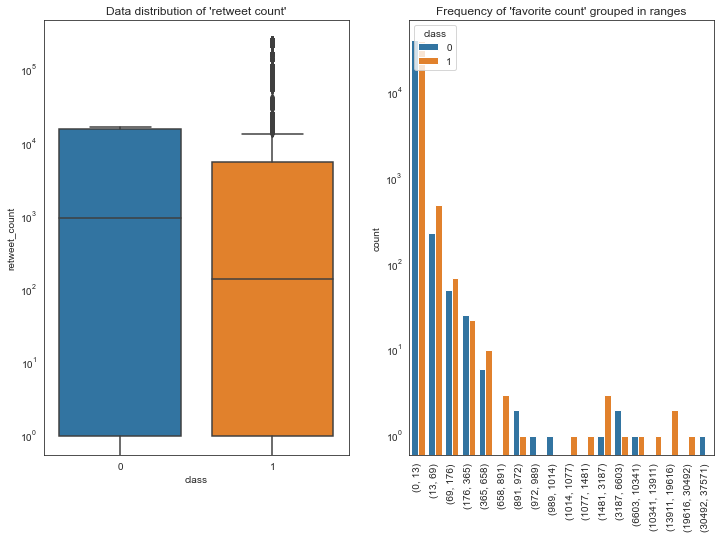

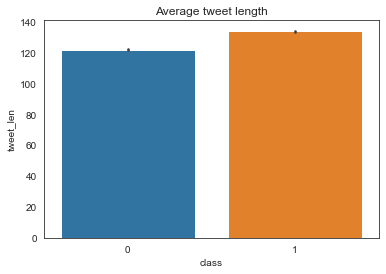

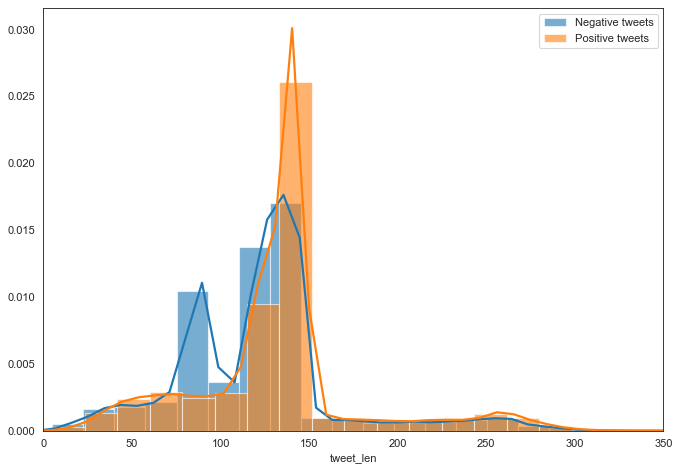

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(12,8))
g = sns.boxplot('class', 'retweet_count', data=training_set, ax=axs[0])
g.set_yscale('log')
axs[0].set_title("Data distribution of 'retweet count'")

fav_count = training_set['favorite_count'].to_numpy().reshape(-1,1)

discretizer = preprocessing.KBinsDiscretizer(n_bins=N_BINS, encode='ordinal', strategy='kmeans')
X_binned = discretizer.fit_transform(fav_count)
X_binned = np.reshape(X_binned, len(X_binned))

ranges = []
for i in range(len(discretizer.bin_edges_[0]) - 1):
    item = (int(discretizer.bin_edges_[0][i]), int(discretizer.bin_edges_[0][i+1]))
    ranges.append(item)

g = sns.countplot(X_binned, hue='class', data=training_set, ax=axs[1])
g.set_yscale('log')
g.set_xticklabels(ranges, rotation=90)
axs[1].set_title("Frequency of 'favorite count' grouped in ranges")

plt.savefig(IMAGE_PATH + 'distribution')
plt.show()

ax = plt.subplot()
ax.set_title("Average tweet length")
sns.barplot('class', 'tweet_len', data=training_set)
plt.savefig(IMAGE_PATH + "tweet_len")

x1 = training_set.loc[training_set['class'] == 1, 'tweet_len']
x2 = training_set.loc[training_set['class'] == 0, 'tweet_len']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2}, norm_hist=True)

plt.figure(figsize=(10,7), dpi= 80)

sns.distplot(x2, label="Negative tweets", **kwargs)
sns.distplot(x1, label="Positive tweets", **kwargs)

plt.xlim(0,350)
plt.legend()
plt.savefig(IMAGE_PATH + 'len_distrib')

In [12]:
tokenizer = LemmaTokenizer()
vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words=stopwords, min_df=3)
X_tfidf = vectorizer.fit_transform(training_set['full_text'])
vectorizer.get_feature_names()

['#100daysofcode',
 '#17',
 '#18',
 '#1stamendment',
 '#1u',
 '#2020',
 '#2020protest',
 '#2020protests',
 '#2020riots',
 '#25thamendmentnow',
 '#2a',
 '#2ndamendment',
 '#8cantwait',
 '#9pmroutine',
 '#ableg',
 '#abolishice',
 '#abolishpolice',
 '#abolishthepolice',
 '#abor',
 '#aboriginallivesmatter',
 '#acab',
 '#acab1312',
 '#acabspring',
 '#academictwitter',
 '#activismisnotterrorism',
 '#adamatraore',
 '#ados',
 '#aewdynamite',
 '#africa',
 '#africanamerican',
 '#agbarr',
 '#ahmaudarbery',
 '#ahmaudaubrey',
 '#airdropalert',
 '#alabama',
 '#alive',
 '#all',
 '#allblacklivesmatter',
 '#allivesmatter',
 '#alljobsmatter',
 '#allliv',
 '#alllivematter',
 '#alllives',
 '#alllivesma',
 '#alllivesmat',
 '#alllivesmater',
 '#alllivesmatter',
 '#alllivesmatters',
 '#alllivesmattter',
 '#ally',
 '#allyship',
 '#alm',
 '#amaudarbery',
 '#amazon',
 '#america',
 '#americacontrump',
 '#americafirst',
 '#american',
 '#americanlivesmatter',
 '#americans',
 '#americanspring',
 '#americaonfire',
 

In [ ]:
pipeline = Pipeline([
    ("tfidf", CountVectorizer(tokenizer=LemmaTokenizer(), binary=True)),
    ('clf', ClfSwitcher()),
])


parameters = [
    {
        'clf__estimator': [BernoulliNB()], # SVM if hinge loss / logreg if log loss
        "tfidf__min_df" : [1],
        "tfidf__stop_words" : [None],
        "tfidf__ngram_range" : [(1,2)],
        'clf__estimator__alpha': [0.1, 0.3, 0.6, 1.0],
    },
]

gscv = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, return_train_score=False, verbose=3)
gscv.fit(training_set['full_text'], training_set['class'])

cv showed up that increasing min_df will result in less accuracy

In [16]:
# TODO function wrapper

results = pd.DataFrame(gscv.cv_results_)
results = results[['param_clf__estimator','param_clf__estimator__alpha','param_tfidf__min_df',	'param_tfidf__ngram_range', 'param_tfidf__stop_words', 'mean_test_score']]
results = results.sort_values(by=['mean_test_score'], ascending=False)

results.to_excel("results_pipeline_Bernoulli.xlsx")

In [9]:
## TODO function wrapper
predictions = gscv.predict(test_set['full_text'])
pred = pd.DataFrame()
pred.insert(0, "Predicted", predictions, True)

pred.to_csv('submission#2.csv',sep=',', index_label='Id')


In [10]:
#TODO MultinomialNB with Vector Count and TFIDF
#TODO XGB boost (?)

#TODO boxplot con tutti gli algoritmi nella validation
#TODO try with keras tokenizer

#TODO visualize useful insights regarding hashtags/users/descriptions/ecc.

#TODO get the labels of test set with Monkey (?)

#TODO usare FreqCount di nlkt per avere info sulle parole più comuni

#Todo